In [1]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/fastbook/__init__.py:18: UserWarning: Missing `graphviz` - please run `conda install fastbook`
  except ModuleNotFoundError: warn("Missing `graphviz` - please run `conda install fastbook`")


In [2]:
import os
from fastbook import *

## Test Bing API

In [3]:
bing_key = os.getenv('BING_API_KEY')
urls = search_images_bing(
    bing_key,
    'sleeping cat'
  )
len(urls),urls[0]


(150,
 {'webSearchUrl': 'https://www.bing.com/images/search?view=detailv2&FORM=OIIRPO&q=sleeping+cat&id=CEC12D0DE33E4B68F6AFB89E68A57D2F3F55BEE7&simid=608044954706969613',
  'name': 'Cute Cat Images New Full HD Pictures Photoshoots',
  'thumbnailUrl': 'https://tse1.mm.bing.net/th?id=OIP.2xtbyxEs4kpIPIo33MotmQHaEo&pid=Api',
  'datePublished': '2019-09-12T04:53:00.0000000Z',
  'isFamilyFriendly': True,
  'contentUrl': 'http://www.reportingday.com/wp-content/uploads/2018/06/Cat-Sleeping-Pics.jpg',
  'hostPageUrl': 'http://www.reportingday.com/nature/animals/cute-cat-images-new-full-hd-pictures/',
  'contentSize': '414836 B',
  'encodingFormat': 'jpeg',
  'hostPageDisplayUrl': 'www.reportingday.com/nature/animals/cute-cat-images-new-full-hd-pictures',
  'width': 2560,
  'height': 1600,
  'hostPageDiscoveredDate': '2018-07-15T00:00:00.0000000Z',
  'thumbnail': {'width': 474, 'height': 296},
  'imageInsightsToken': 'ccid_2xtbyxEs*cp_A35A4F5231AA96D915FC19A2BB1865EA*mid_CEC12D0DE33E4B68F6AFB8

In [4]:
images = urls.attrgot('content_url')

In [5]:
len(images)

150

## Download images for dataset

In [6]:
# Cell runs for about 1 minute

label_terms = [
  ('asleep', 'sleeping cat'),
  ('asleep', 'cat asleep'),
  ('asleep', 'cat sleep'),
  ('awake', 'cat eating'),
  ('awake', 'cat playing'),
  ('awake', 'cat looking')
]
path = Path('cats')

if path.exists():
    print('Dataset already exists. Skipping download to avoid duplicate images.')
else:
    print('Beginning download...')

    for label, term in label_terms:
        dest = path / label 
        dest.mkdir(exist_ok=True)
        results = search_images_bing(bing_key, term)
        urls = results.attrgot('contentUrl') # <-- NOT content_url
        print(f"Getting results for {term} and storing {len(urls)} urls to {dest}")

        download_images(dest, urls=urls)

Dataset already exists. Skipping download to avoid duplicate images.


In [7]:
filenames = get_image_files(path)

In [8]:
failed = verify_images(filenames)
print(f"Deleting {len(failed)} broken image files")
failed.map(Path.unlink)

Deleting 0 broken image files


(#0) []

In [36]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock),  # map from image to label/category
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=23),
    get_y=parent_label,  # label defined by enclosing directoy name
    item_tfms=Resize(128)
)

In [37]:
data_loaders = cats.dataloaders(path)

## Inspect some sample images

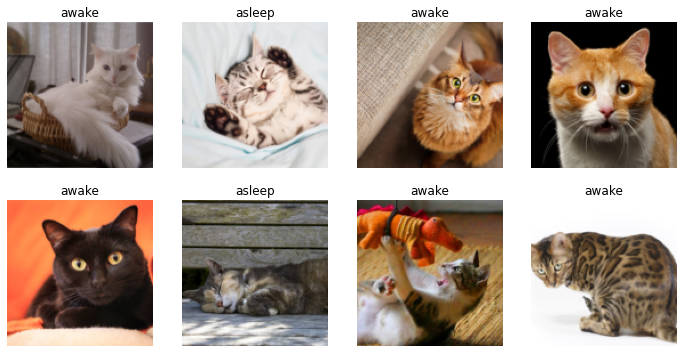

In [38]:
data_loaders.valid.show_batch(max_n=8, nrows=2)

In [39]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
data_loaders = cats.dataloaders(path)

## Train simple classification model

In [40]:
model = cnn_learner(data_loaders, resnet18, metrics=error_rate)
model.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.197441,0.524387,0.215385,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.436741,0.311031,0.153846,00:06
1,0.430743,0.211250,0.123077,00:06
2,0.344626,0.164027,0.076923,00:06
3,0.303374,0.148211,0.092308,00:06
4,0.275003,0.145633,0.076923,00:06
5,0.241573,0.167361,0.092308,00:06
6,0.212482,0.167717,0.076923,00:06
7,0.186849,0.179456,0.061538,00:06
8,0.169806,0.172279,0.061538,00:06
9,0.154445,0.170666,0.061538,00:05


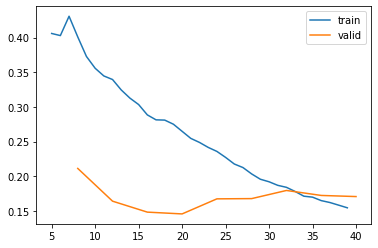

In [41]:
model.recorder.plot_loss()

# Save model

In [42]:
model.export()

In [43]:
!ls

cats  export-1.pkl  export.pkl	fastai-cats.ipynb  test-ginny


## Inspect model predictions

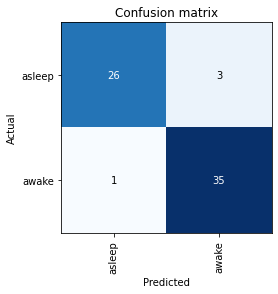

In [44]:
interpretation = ClassificationInterpretation.from_learner(model)
interpretation.plot_confusion_matrix()

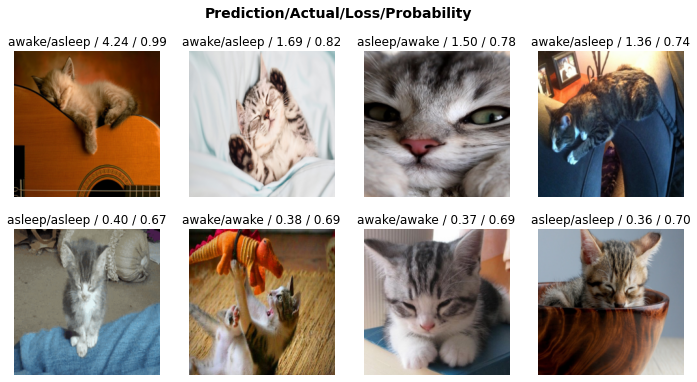

In [45]:
interpretation.plot_top_losses(8)

## Cleanup dataset 
When done here, re-train the model in a previous cell. You will also have to reset the data loaders, as file locations may have changed after fixing the dataset.

In [19]:
from fastai.vision.widgets import ImageClassifierCleaner

In [20]:
# ImageClassifierCleaner(model)
cleaner = ImageClassifierCleaner(model)
cleaner

/home/flo/miniconda3/envs/practice-ml/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [21]:
for idx in cleaner.delete():
    print(f'Deleting: {cleaner.fns[idx]}')
    cleaner.fns[idx].unlink()
    

In [22]:
def get_unique_filename(directory, ext='jpg'):
    directory = Path(directory)
    all_files = Path(directory).glob('*')
    all_files = list(all_files)
    i = len(all_files)
    fname = directory / f'{i}.{ext}'
    while fname.exists():
        i += 1
        fname = directory / f'{i}.{ext}'
    return fname
get_unique_filename(path/'asleep')

Path('cats/asleep/186.jpg')

In [23]:
for idx, to_label in cleaner.change():
    print(idx)
    print(cleaner.fns[idx])
    path_to = get_unique_filename(path / to_label)
    shutil.move(str(cleaner.fns[idx]), path_to)

## Test inference

In [46]:
model_inf = load_learner('export.pkl')

In [47]:
model_inf.predict('test-ginny/asleep-1.jpg')

('asleep', tensor(0), tensor([0.9931, 0.0069]))

In [48]:
model_inf.predict('test-ginny/asleep-2.jpg')

('asleep', tensor(0), tensor([0.6667, 0.3333]))

In [49]:
model_inf.predict('test-ginny/awake-1.jpg')

('asleep', tensor(0), tensor([0.9390, 0.0610]))

In [50]:
model_inf.predict('test-ginny/awake-2.jpg')

('awake', tensor(1), tensor([0.0383, 0.9617]))